In [1]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


In [2]:
import sys
sys.path.insert(0, 'python')
from PSF_optimization import *
from read_net import *
import pylab as plt
%matplotlib inline
from scipy.stats import linregress
from linear_plot import *

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [3]:
lat, lon, year, month, day = 37.474469, 117.346456, 2016, 3, 10
h,v = mtile_cal(lat, lon)
#pr=get_wrs(lat, lon)
#path, row = pr[0]['path'],pr[0]['row']
path, row = 122, 34
Hfiles = glob.glob(directory +'l_data/LC8%03d%03d%d*LGN00_sr_band1.tif'%(path, row, year))
Hfiles

['/data/store01/data_dirs/students/ucfafyi/S2_MODIS/l_data/LC81220342016038LGN00_sr_band1.tif',
 '/data/store01/data_dirs/students/ucfafyi/S2_MODIS/l_data/LC81220342016070LGN00_sr_band1.tif',
 '/data/store01/data_dirs/students/ucfafyi/S2_MODIS/l_data/LC81220342016086LGN00_sr_band1.tif',
 '/data/store01/data_dirs/students/ucfafyi/S2_MODIS/l_data/LC81220342016134LGN00_sr_band1.tif',
 '/data/store01/data_dirs/students/ucfafyi/S2_MODIS/l_data/LC81220342016150LGN00_sr_band1.tif']

In [4]:
doy = 70
Hfile = directory +'l_data/LC8%03d%03d%d%03dLGN00_toa_'%(path, row, year, doy)
Lfile = glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(year,doy,h,v))[0]

In [5]:
#psf = PSF_optimization(2016, 3, 10, 70, lat, lon ,'l8')
#retval = psf.Land_PSF_optimization()
#para = np.array([np.hstack((i[0], i[1])) for i in retval[0]])
#para[para[:,-1].argmin(axis=-1)]

In [6]:
psf = 1.14719796e+01,   1.51676255e+01,   7.69298694e+00, 3.25671574e+01,   4.54695201e+00,   1.80884279e-02
psf

(11.4719796, 15.1676255, 7.69298694, 32.5671574, 4.54695201, 0.0180884279)

In [7]:
def read_meta(Hfile):
    
    with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
        for line in inF:
            if 'CLOUD_COVER ' in line:
                cloud_cover =  float(line.split('= ')[1])
    if cloud_cover<20:
        #print 'Less than 20% cloud.'
        b1 = gdal.Open(Hfile+'band1.tif').ReadAsArray()
        corners = b1.shape
        dic = {}
        with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
            for line in inF:
                if ('CORNER_' in line)&('LAT_PRODUCT' in line):
                    dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
                elif ('CORNER_' in line)&('LON_PRODUCT' in line):
                    dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
                elif 'ROLL_ANGLE' in line:
                    vza = float(line.split(' = ')[1])
                elif 'SUN_AZIMUTH' in line:
                    saa = float(line.split(' = ')[1])
                elif 'SUN_ELEVATION' in line:
                    sza = float(line.split(' = ')[1])
        with open('Landsat_azm.pkl', 'r') as savefile:
            Landsat_azm = pkl.load(savefile)

        vaa = np.nanmean(Landsat_azm[(Landsat_azm[:,2]==path)&(Landsat_azm[:,3]==row)].squeeze()[:2])
        
        return sza, saa, vza, vaa, dic, corners
    else:
        print 'To much cloud: ', cloud_cover
        return None  
sza, saa, vza, vaa, dic, corners = read_meta('l_data/LC81220342016070LGN00_sr_')
L_inds, H_inds = ML_geo_trans(lat, lon, dic, corners)
Lx, Ly = L_inds
Hx, Hy = H_inds

In [8]:
tems = np.zeros((3,6))
tems[0,:] = sza
tems[1,:] = vza
tems[2,:] = vaa-saa
brdf, qa = get_brdf_six(Lfile, (tems[0], tems[1], tems[2]), bands=[3,4,1,2,6,7], flag=None, Linds= L_inds)

cloud = gdal.Open(Hfile[:-5]+'_cfmask.tif').ReadAsArray()
cl_mask = cloud==4 # cloud pixels; strictest way is to set the clear pixels with cloud==0
struct = ndimage.generate_binary_structure(2, 2)
dia_cloud = ndimage.binary_dilation(cl_mask, structure=struct, iterations=20).astype(cl_mask.dtype)

In [9]:
def gaussian( xstd, ystd, angle, norm = True):
    win = int(round(max(2*1.69*xstd, 3*ystd)))
    winx = win*2**0.5
    winy = win*2**0.5

    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-win/2: center[0]+win/2, center[1]-win/2:center[1]+win/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus 
    
shape =  dia_cloud.shape
xstd,ystd, angle, xs, ys = psf[:5]
shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
val = (Hx+xs<shape[0])&(Hy+ys<shape[1])&(Hx+xs>0)&(Hy+ys>0)
ker = gaussian(xstd,ystd,angle,True)

In [10]:
def L8_get_to_cor(band, Hfile=None, ker = None, dia_cloud=None):
    fname = Hfile + 'band%s.tif'%band
    data = gdal.Open(fname).ReadAsArray()*0.0001
    mask = ~(data<=0).astype('bool')
    struct = ndimage.generate_binary_structure(2, 2)
    small_mask = ndimage.binary_erosion(mask, structure=struct, iterations=20).astype(mask.dtype)
    val_mask = (~dia_cloud)&small_mask
    used_mask = val_mask[shx[val], shy[val]]
    used_data = signal.fftconvolve(data, ker, mode='same')[shx[val], shy[val]]
    
    return used_data, used_mask 
bands = [2,3,4,5,6,7]
par = partial(L8_get_to_cor, Hfile=Hfile, ker = ker, dia_cloud=dia_cloud)
retval = parmap(par, bands, nprocs=len(bands))

In [11]:
L8_mask = np.array(retval)[:,1,:].astype(bool)
L8_data = np.array(retval)[:,0,:]
l8 = L8_data.copy()
Mcomb_mask = np.all(qa==0, axis=0)
Scomb_mask = np.all(L8_mask, axis = 0)
l8[:,(~Scomb_mask)|(~Mcomb_mask[val])]=np.nan
l8[np.isnan(l8)], brdf[np.isnan(brdf)] = -9999999, -9999999
mas = np.all((brdf[:,val]>0)&(brdf[:,val]<1)&(l8>0)&(l8<1), axis=0)
to_cor = shx[val][mas], shy[val][mas],l8[:,mas], brdf[:,val][:,mas]

/opt/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


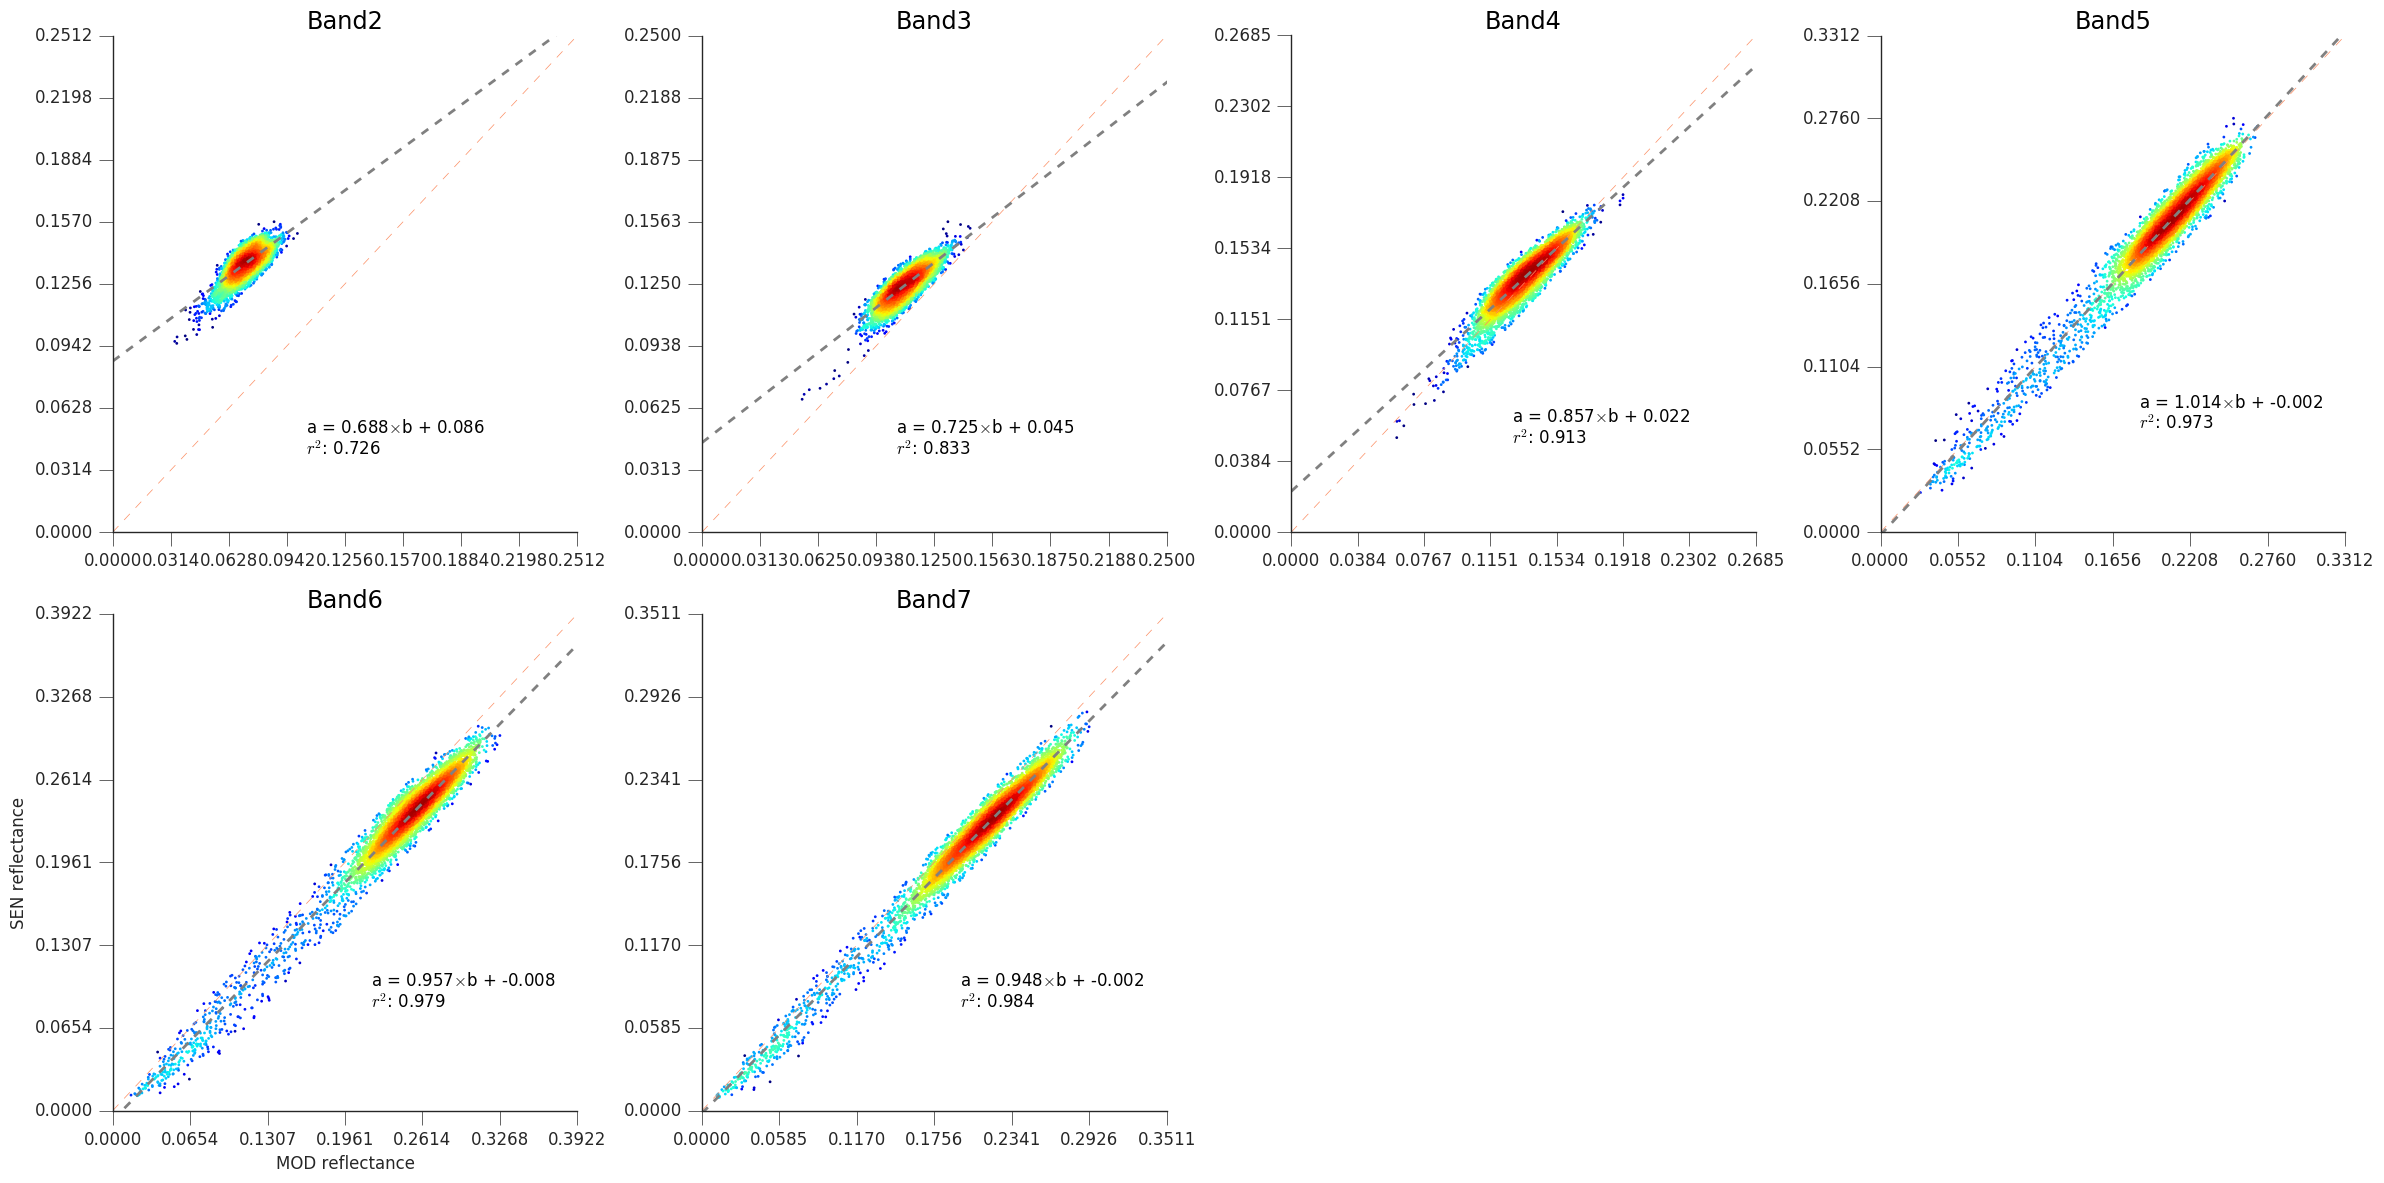

In [12]:
titles='Band2','Band3','Band4','Band5','Band6','Band7',
linear_plots(to_cor[3], to_cor[2], cmap=plt.cm.get_cmap('jet'), titles=titles, three_sigma=1)

In [13]:
L8_emus = parallel_rw_pkl(None, '6S_emulation_L8_', 'r')
aot = read_net(year, month,day, np.arange(lat,lat+1, 0.125), np.arange(lon,lon+2, 0.125), dataset='aot')
twv = read_net(year, month,day, np.arange(lat,lat+1, 0.125), np.arange(lon,lon+2, 0.125), dataset='wv')
tco = read_net(year, month,day, np.arange(lat,lat+1, 0.125), np.arange(lon,lon+2, 0.125), dataset='tco')

In [14]:
import gdal
def elevation(lat, lon, north=True, east=True):
    lats = range( int(lat.min()), int(lat.max())+1)
    lons = range( int(lon.min()), int(this_lon.max())+1)
    eles=np.zeros_like(lat)
    for lat0 in lats:
        for lon0 in lons:
            if lat0>=0:
                lat_name = 'N%d'%int(lat0)
            elif lat0<0:
                lat_name = 'S%d'%int(lat0)
            else:
                'Wrong lat given, and float is expected!'
            if lon0>=0:
                lon_name = 'E%d'%int(lon0)
            elif lon0<0:
                lon_name = 'W%d'%int(lon0)
            else:
                'Wrong lon given, and float is expected!'
            fname = 'SRTM/'+lat_name+lon_name+ '.hgt'
            mask = (lat>lat0)&(lat<lat0+1)&(lon>lon0)&(lon<lon0+1)
            g = gdal.Open(fname)
            geo = g.GetGeoTransform()
            l_lon, lon_size,l_lat, lat_size, = geo[0], geo[1],geo[3],geo[5]
            x, y = ((lon-l_lon)/lon_size).astype(int), ((lat-l_lat)/lat_size).astype(int)
            ele = g.ReadAsArray()
            eles[mask] = ele[x[mask],y[mask]]    
    return eles

def cost(p, args = None):
    if any(p>10) or any(p<0):
        return 10000
    else:
        #'aot550', 'water', 'ozone'
        aot550, water = p
        TOA_refs, M_refs, angles, ele, ozone = args        
        sz, sa, vz, va = angles        
        Sur_refs = [L8_emus[ind][0].predict(np.array([[toa_ref, aot550, water, ozone, \
                                                            np.sin(sz), np.sin(vz), np.cos((sa-va)), \
                                                            ele],]))[0][0] for ind, toa_ref in enumerate(TOA_refs)]
        Sur_refs = np.array(Sur_refs)
        M_refs = np.array(M_refs)
        cost = sum(abs(Sur_refs-M_refs)*w)    
        return cost


def opt(ind):
    
    #sent_refs, modis_refs = np.array([refs[ii][tuple(aoi[ind])] for ii in range(7)]).T
    
    TOA_refs = to_cor[2][:,ind]
    M_refs = to_cor[3][:,ind]
    m = mgrs.MGRS()
    pix_lat, pix_lon = cor_inter(np.array([[to_cor[0][ind], to_cor[1][ind]],]).T, dic, corners)
    ele = eles[ind]
    inx_lat, inx_lon = (np.abs(lats-pix_lat)).argmin(),(np.abs(lons-pix_lon)).argmin()
    aot0, tcw0, tco0 = aot[inx_lat, inx_lon], twv[inx_lat, inx_lon]/10., tco[inx_lat, inx_lon]
                                                          
    angles =[i*np.pi/180 for i in [sza, saa, vza, vaa]]
    
    ozone = tco0*46.698
    
    args = TOA_refs, M_refs , angles, ele, ozone
    #print args
    p = aot0, tcw0 
    psolve = optimize.fmin_l_bfgs_b(cost,p, iprint=-1, approx_grad=1, args=(args,))
    return [to_cor[0][ind],to_cor[1][ind],psolve]

wl = np.array([482.04,561.41,654.59,864.67,1608.86,2200.73])/1000
alpha = 1.42 #angstrom exponent for continental type aerosols
w = (np.array(wl)/wl[0])**(-alpha)
lats, lons = np.arange(lat,lat+1, 0.125), np.arange(lon,lon+2, 0.125)
this_lat, this_lon = cor_inter(np.array([to_cor[0], to_cor[1]]), dic, corners)
eles = elevation(this_lat, this_lon)/1000.

In [ ]:
opt(0)

In [ ]:
pool = multiprocessing.Pool(processes=16)
retval = pool.map(opt, range(len(to_cor[0])))
pool.close()
pool.join()

In [4]:
retval = parallel_rw_pkl(None, 'L8_aot_', 'r')

In [17]:
paras = np.array([np.hstack((i[2][0], i[2][1])) for i in retval])

(0, 0.1)

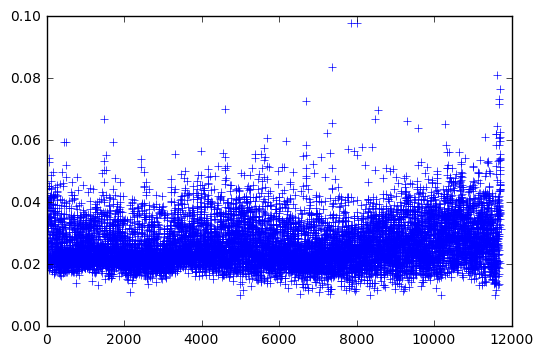

In [18]:
plt.plot(paras[:,-1], '+')
plt.ylim(0,0.1)

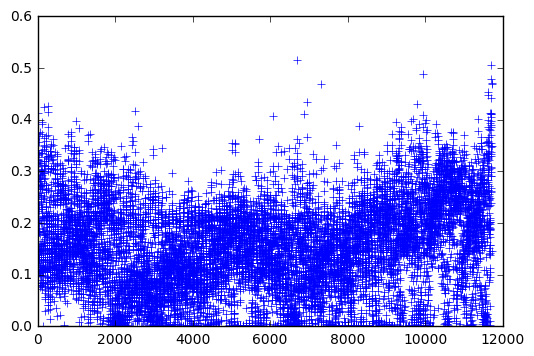

In [20]:
plt.plot(paras[:,0], '+')

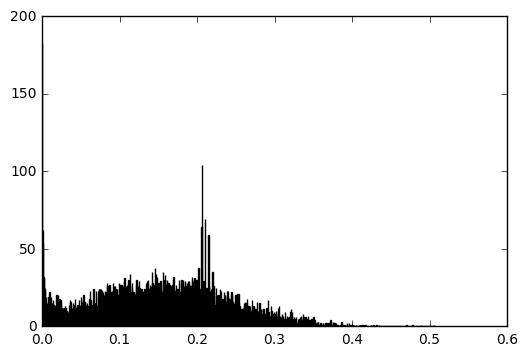

In [29]:
hist = plt.hist(paras[:,0][paras[:,-1]<0.06], bins=1000)

In [54]:
paras[:,0].mean(), aot.mean(), twv.mean()/10, tco.mean()*46.698

(0.15353095948216947,
 0.18879667014183876,
 0.21850598135653615,
 0.42064283537534503)

(0, 0.3)

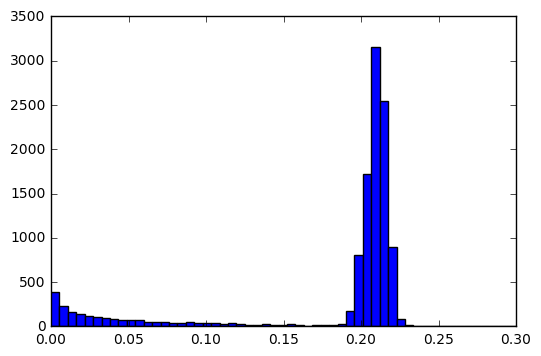

In [45]:
hist = plt.hist(paras[:,1][paras[:,-1]<0.06], bins=1000)
plt.xlim(0,0.3)

(0, 0.3)

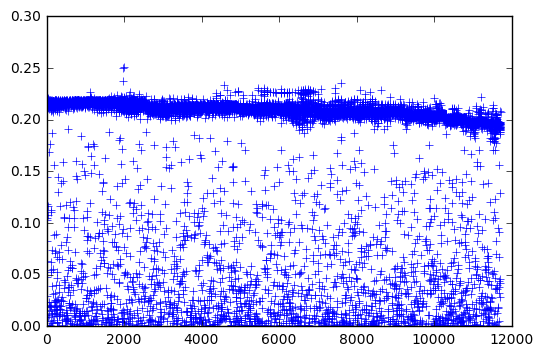

In [48]:
plt.plot(paras[:,1], '+')
plt.ylim(0,0.3)

In [18]:
import gdal
def elevation(lat, lon, north=True, east=True):
    lats = range( int(lat.min()), int(lat.max())+1)
    lons = range( int(lon.min()), int(lon.max())+1)
    eles=np.zeros_like(lat)
    for lat0 in lats:
        for lon0 in lons:
            if lat0>=0:
                lat_name = 'N%d'%int(lat0)
            elif lat0<0:
                lat_name = 'S%d'%int(lat0)
            else:
                'Wrong lat given, and float is expected!'
            if lon0>=0:
                lon_name = 'E%d'%int(lon0)
            elif lon0<0:
                lon_name = 'W%d'%int(lon0)
            else:
                'Wrong lon given, and float is expected!'
            fname = 'SRTM/'+lat_name+lon_name+ '.hgt'
            mask = (lat>lat0)&(lat<lat0+1)&(lon>lon0)&(lon<lon0+1)
            g = gdal.Open(fname)
            geo = g.GetGeoTransform()
            l_lon, lon_size,l_lat, lat_size, = geo[0], geo[1],geo[3],geo[5]
            x, y = ((lon-l_lon)/lon_size).astype(int), ((lat-l_lat)/lat_size).astype(int)
            ele = g.ReadAsArray()
            eles[mask] = ele[x[mask],y[mask]]    
    
    return eles

def cost(p, args = None):
    #if any(p>10) or any(p<0):
    #    return 10000,np.zeros(2)
    #else:
        #'aot550', 'water'
    aot550, water = p
    angles, ele, ozone = args        
    sz, sa, vz, va = angles        
    pas = [to_cor[2], aot550, water, ozone, np.sin(sz), np.sin(vz), np.cos(sa-va), ele]

    paras =  np.zeros((len(bands), len(to_cor[2][0]), 8))
    for i in range(8):
        paras[:,:,i]=  pas[i]

    J = 0
    J_prime = np.zeros(2)
    for i in range(6):
        fwd, grad = L8_emus[i][0].predict(paras[i], do_unc=0)
        # select from set of gradients
        g0,g1 = grad[:,1],grad[:,2]
        #
        residual = np.array(fwd-to_cor[3][i])
        J_prime_wrt0_i = w[i] * residual * g0 
        J_prime_wrt1_i = w[i] * residual * g1
        J_i = 0.5 * w[i] * (residual**2)[:].sum()

        J += J_i
        J_prime += np.array([J_prime_wrt0_i,J_prime_wrt1_i])[:,:].sum(axis=1)

    return J #, J_prime

def opt():
    
    this_lat, this_lon = cor_inter(np.array([to_cor[0], to_cor[1]]), dic, corners)
    ele = elevation(this_lat, this_lon)/1000.
                                                          
    angles =[i*np.pi/180 for i in [sza, saa, vza, vaa]]
    args = angles, 0.002, 0.41
    bounds = ((0.,None),(0.,None))
    
    p0 = 0.18879667014183876, 0.21850598135653616
    
    psolve = optimize.fmin_l_bfgs_b(cost,p0, approx_grad=1, iprint=1, bounds=bounds,fprime=None,args=(args,))
    this_lat, this_lon = cor_inter(np.array(zip(to_cor[0], to_cor[1])).T,  dic, corners)
    ele = elevation(this_lat, this_lon)/1000.
    
    #inx_lat, inx_lon = (np.abs(lats-this_lat)).argmin(),(np.abs(lons-this_lon)).argmin()
    #aot0, tcw0, tco0 = aot[inx_lat, inx_lon], twv[inx_lat, inx_lon]/10., tco[inx_lat, inx_lon]
                                                          
    #angles =[i*np.pi/180 for i in [sza, saa, vza, vaa]]
    
    #ozone = 0.36904032414188315
    
    #args = TOA_refs, M_refs , angles, ele, ozone
    
    return psolve



wl = np.array([482.04,561.41,654.59,864.67,1608.86,2200.73])/1000
alpha = 1.42 #angstrom exponent for continental type aerosols
w = (np.array(wl)/wl[0])**(-alpha)
#w = 1/aot_grad.mean(axis=1)
#w = (w**3+w[::-1]**3)/2

In [19]:
opt()

(array([ 0.15259138,  0.        ]),
 2.451477300274274,
 {'funcalls': 30,
  'grad': array([  2.97539771e-05,   1.75387838e-01]),
  'nit': 5,
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'warnflag': 0})

In [20]:
this_lat, this_lon = cor_inter(np.array(zip(to_cor[0], to_cor[1])).T,  dic, corners)
ele = elevation(this_lat, this_lon)/1000.
angles =[i*np.pi/180 for i in [sza, saa, vza, vaa]]
args = angles, ele, 0.41

In [21]:
gridx, gridy = np.mgrid[0.05:0.35:0.3/100, 0.05:0.25:0.2/100]
ite = zip(gridx.ravel(), gridy.ravel())

In [22]:
par = partial(cost, args=args) 
retval = parmap(par, ite, nprocs=12)

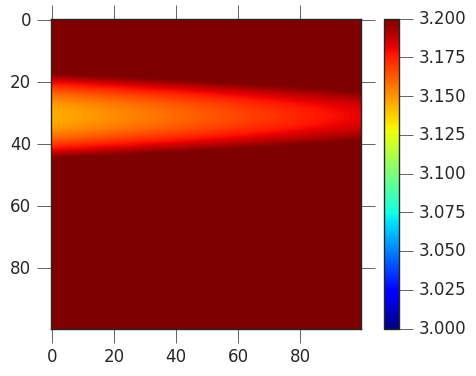

In [31]:
plt.imshow(np.array(retval).reshape(100, 100), vmin=3,vmax=3.2)
plt.colorbar()

In [37]:
np.array(ite)

array([[ 0.05 ,  0.05 ],
       [ 0.05 ,  0.052],
       [ 0.05 ,  0.054],
       ..., 
       [ 0.347,  0.244],
       [ 0.347,  0.246],
       [ 0.347,  0.248]])

In [38]:
parallel_rw_pkl(retval, 'aerosol_aero_map','w')

Length of data: 10000
Length of data: 35


In [52]:
patch = (to_cor[0]<2000)&(to_cor[1]<2000)
to_cor[3][:,patch], to_cor[2][:,patch]

(masked_array(data =
  [[0.07436557329827671 0.07418506257204566 0.07738661593238354 ...,
   0.06533914876309296 0.06225012670866935 0.06371940374500971]
  [0.11292744518546541 0.11241899816460449 0.11357542384338463 ...,
   0.09880357428143699 0.09597146668798229 0.09753999919781953]
  [0.14941706193030127 0.14887552975160812 0.14841706193030127 ...,
   0.11516570191294002 0.11164948809038969 0.11220902048984556]
  [0.2041725932464874 0.2029138696808663 0.20462387006206506 ...,
   0.21747740167857965 0.2179802942558329 0.22168544311903537]
  [0.2688457631308984 0.2742384638899702 0.26294695483869857 ...,
   0.23527131833690368 0.22471840114721664 0.23372740125759797]
  [0.2536739982557467 0.24541487143669602 0.24650442387420024 ...,
   0.17222631778499695 0.17115833836468017 0.1728844027323384]],
              mask =
  [[False False False ..., False False False]
  [False False False ..., False False False]
  [False False False ..., False False False]
  [False False False ..., False Fa